In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from random import *
from matplotlib import pyplot as plt
import numpy as np
import GPy
from datetime import datetime

# change here
model_class_names = [6]

m_test_set_path = "./MALLAT/MALLAT_TEST"


In [2]:
X_file_path = "./MALLAT_files/X_" + str(model_class_names)  + ".npy"
Y_file_path = "./MALLAT_files/Y_" + str(model_class_names)  + ".npy"
model_path = "./MALLAT_files/model_save" + str(model_class_names) + ".npy"

X_load = np.load(X_file_path)
Y_load = np.load(Y_file_path)


kern_class = GPy.kern.Matern32(input_dim=1, variance=1.5, lengthscale=2.5, active_dims=[0], name='class')
kern_replicate = GPy.kern.Matern32(input_dim=1, variance=.1, lengthscale=2.5, active_dims=[0], name='replicate')
k_hierarchy = GPy.kern.Hierarchical(kernels=[kern_class, kern_replicate])

In [3]:
m_load = GPy.models.GPRegression(X_load, Y_load, initialize=False, kernel=k_hierarchy)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(model_path) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)

 C:\Users\capec\Anaconda3\lib\site-packages\paramz\parameterized.py:57: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!



Name : GP regression
Objective : -1144.888708211445
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                   |              value  |  constraints  |  priors
  hierarchy.class.variance         |     0.467731851025  |      +ve      |        
  hierarchy.class.lengthscale      |      19.5899048001  |      +ve      |        
  hierarchy.replicate.variance     |    0.0858280993125  |      +ve      |        
  hierarchy.replicate.lengthscale  |      29.6095213847  |      +ve      |        
  Gaussian_noise.variance          |  6.08979871692e-12  |      +ve      |        


 C:\Users\capec\Anaconda3\lib\site-packages\GPy\plotting\gpy_plot\plot_util.py:341: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


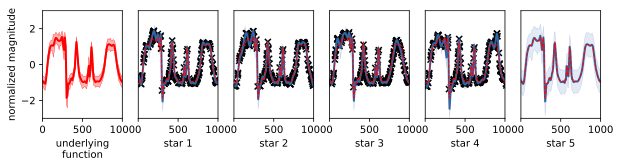

In [6]:
plt.figure(figsize=(10,1.98))
#to plot the mean function g_n(t), predict using only the 'kern_class' kernel

Xplot = np.linspace(1,1025, 100)[:,None]
mu, var = m_load.predict(Xplot, kern=kern_class)
ax = plt.subplot(1,6,1)
GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
plt.ylabel('normalized magnitude')
plt.xlabel('underlying\nfunction')

#plot each of the functions f_{nr}(t)
for r in range(1,6):
    ax = plt.subplot(1,6,r+1)
    m_load.plot(fixed_inputs=[(1,r)],ax=ax, which_data_rows=X_load[:,1]==r, legend=False)
    plt.xlabel('star %i'%r)
    plt.plot(Xplot, mu, 'r--', linewidth=1)

    
GPy.plotting.matplot_dep.base_plots.align_subplots(1,6, xlim=(1,1000), ylim=(-3,3))

# fig_name = 'result' + datetime.now().strftime("%Y-%m-%d %H-%M") + '.png'
fig_name = "./MALLAT_test_result/model_class_name_" + str(model_class_names);
plt.savefig(fig_name);


In [12]:
class_names_test = np.loadtxt(m_test_set_path, delimiter=',', usecols=[0])

m_test = np.loadtxt(m_test_set_path, delimiter=',', usecols=range(1, 1025))
m_test -= m_test.mean(1)[:,np.newaxis]
m_test /= m_test.std(1)[:,np.newaxis]


In [13]:
from scipy.interpolate import interp1d
def plot_test(sort_indeies, type, test_class_name):
    plt.figure(figsize=(18,1.85))
    Xplot = np.linspace(1,1025, 100)[:,None]
    mu, var = m_load.predict(Xplot, kern=kern_class)
    ax = plt.subplot(1,11,1)
    GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
    plt.ylabel('normalized magnitude')
    plt.xlabel('underlying\nfunction')

    # X_r = np.arange(1,1025)
    # Y_r = light_curve_test[test_indices[0],:]

    # print(X_r.shape, Y_r.shape)

    for index, item in enumerate(sort_indeies):

        X_r = np.arange(1,1025)
        Y_r = m_test[int(item),:]

        smooth_func = interp1d(X_r, Y_r, kind='cubic')
        # Xnew = np.linspace(X_r.min(), X_r.max(), num=sample_time_index_num, endpoint=True)
        plt.subplot(1, 11, index+2)
        plt.plot(X_r, Y_r, 'kx', mew=2)
        # plt.plot(Xnew, smooth_func(Xnew), '-')
        plt.xlabel('star %i'%item)
        plt.plot(Xplot, mu, 'r--', linewidth=1)
    
    GPy.plotting.matplot_dep.base_plots.align_subplots(1,11, xlim=(1,1000), ylim=(-3,3))
    fig_name = "./MALLAT_test_result/model_class_name_" + str(model_class_names) +"-test_class-" + str(test_class_name) + "_" + type;
    plt.savefig(fig_name);

[[  1.83300000e+03  -5.84612793e-01]
 [  1.45600000e+03  -5.65551072e-01]
 [  1.51200000e+03  -4.73874659e-01]
 [  5.84000000e+02  -4.62209945e-01]
 [  1.00800000e+03  -4.11365703e-01]
 [  3.01000000e+02  -3.86754202e-01]
 [  1.78200000e+03  -3.56625160e-01]
 [  1.93900000e+03  -3.20295792e-01]
 [  1.48000000e+03  -2.91220383e-01]
 [  1.09500000e+03  -2.85545452e-01]
 [  2.00400000e+03  -2.71200953e-01]
 [  2.11200000e+03  -2.61778732e-01]
 [  8.34000000e+02  -2.49267480e-01]
 [  5.95000000e+02  -2.40301711e-01]
 [  7.69000000e+02  -2.34949094e-01]
 [  1.81400000e+03  -2.28725273e-01]
 [  6.69000000e+02  -2.24224449e-01]
 [  4.40000000e+02  -2.16111504e-01]
 [  1.43600000e+03  -2.06724712e-01]
 [  9.30000000e+01  -1.99294372e-01]
 [  1.19500000e+03  -1.99004265e-01]
 [  3.15000000e+02  -1.94845475e-01]
 [  1.05700000e+03  -1.93190953e-01]
 [  9.02000000e+02  -1.89413140e-01]
 [  1.20100000e+03  -1.80943459e-01]
 [  4.24000000e+02  -1.73207601e-01]
 [  1.49700000e+03  -1.73067144e-01]
 

[ 1833.  1456.  1512.   584.  1008.   301.  1782.  1939.  1480.  1095.]


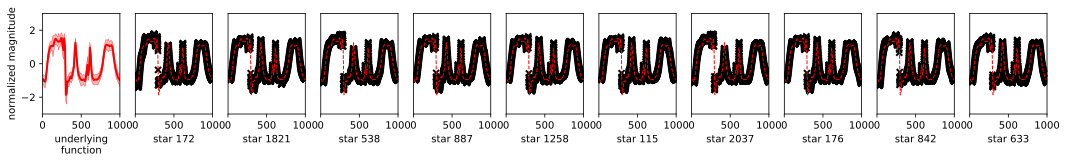

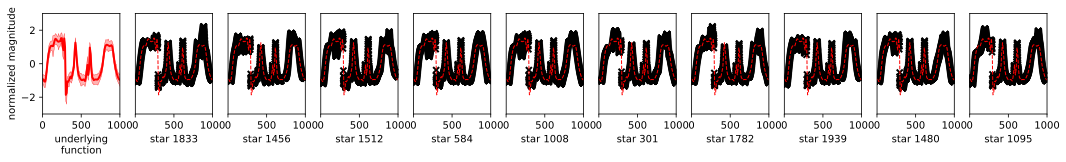

In [15]:
for test_model_class in range(6,7):
    test_indices = [i for i,cn in enumerate(class_names_test) if cn == test_model_class]
    log_pre_density_result = np.ones(len(test_indices)) * 9999
    log_pre_density_result = log_pre_density_result.reshape(-1,1)
    x_test = np.arange(1,1025)[:,None]
    mu_star, var_star = m_load.predict_noiseless(x_test, kern=kern_class) # read the source code for log_predictive
    for index in range(len(test_indices)):
        y_test = m_test[test_indices[index],:].reshape(-1,1)
        log_pre_density_result[index] = np.average(m_load.likelihood.log_predictive_density(y_test, mu_star, var_star))
    
    test_indices = np.asarray(test_indices)
    test_indices = test_indices.reshape(-1,1)

    combine_result = np.concatenate((test_indices, log_pre_density_result), axis=1)
    sorted_result = np.sort(combine_result.view('f8,f8'), order=['f1'], axis=0).view(np.float)
    print(sorted_result)
    
    result_file_name = "./MALLAT_test_result/sorted_result_model-" + str(model_class_names) + "class-" + str(test_model_class) + ".csv";
    np.savetxt(result_file_name, sorted_result, delimiter=",",fmt='%d,%1.9f')
    
    test_sort_last_indices = sorted_result[-10:][:,0]
    print(test_sort_last_indices)
    plot_test(test_sort_last_indices,"last",test_model_class)
    
    test_sort_top_indices = sorted_result[:10:][:,0]
    print(test_sort_top_indices)
    plot_test(test_sort_top_indices, "top",test_model_class)